# Proyecto I. Lector de Matrículas

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">En este proyecto se quiere desarrollar una aplicación capaz de encontrar las matrículas de coches en las imágenes y extraer sólo la parte de la matrícula y conseguir en texto máquina el texto de la matrícula en la imagen.</div>

Como planteamiento inicial:
- se usará el framework de _Detectron2_ para encargarse de la parte de detección de las matrículas.
- se utilizará el módulo _pytesseract_ para encargarse de la extracción del texto de la imagen.

<div style="text-align: justify; margin-right:3em">Para se utilizará el <a href="https://www.kaggle.com/andrewmvd/car-plate-detection">dataset</a> de <b>Kaggle</b> para entrenar un modelo personalizado. Es posible que el equipo no sea el más adecuado para realizar un proceso de entramiento, por lo que en el archivo <code>config.yaml</code> y <code>model_final.pth</code> se encuentra la configuración para un modelo específico para esta tarea. En el caso de que se quisiera realizar el proceso de entrenamiento y no se pudiese realizar en el equipo, se recomienda utilizar la herramienta <a href="https://colab.research.google.com/">Google Colab</a>. Si se usa esta herramienta hay que habilitar el uso de GPU para acelerar todo lo posible el proceso de entrenamiento.</div>

## Utils

In [1]:
# Needed Modules
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
import xml.etree.ElementTree as et # module for xml files
import cv2
import os

In [2]:
def imshow(im, reverse=False):
    import cv2
    from IPython.display import display, Image
    if reverse:
        im = im[:,:,::-1]
    _,ret = cv2.imencode('.jpg', im) 
    display(Image(data=ret))

## Entrenamiento

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">Para realizar el proceso de entrenamiento se debe adaptar la información que tenemos en el dataset al formato de dataset de <i>Detectron2</i> para conseguirlo, se creará una función que lea todos los archivos <code>.xml</code> del dataset y los transforme. Para profundizar más en el formato de <code>Detectron2</code> se recomienda revisar la <a href="https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#use-custom-datasets">documentación</a>.</div>

In [3]:
from detectron2.structures import BoxMode
import xml.etree.ElementTree as et

# Function to extract and adapt the information from the 
# xml files.
def proccess_dataset(ann_path='./images/archives/annotations'):
    """
    Transform the data from the xml file of the dataset to a Detectron2 format
    
    Parameters
    -----------
    - ann_path : str -> path to the annotations folder of the dataset
    
    Return
    -------
    - dataset : list[dict] -> a list of dicts with the data in a Detectron2 format
    """
    dataset = []
    for xml_file in os.listdir(ann_path):
        tree = et.parse(os.path.join(ann_path, xml_file))
        root = tree.getroot()
 
        # Extract the data in the XML files and organize them in a dictionary
        info = {}
        info['object'] = []
 
        for entry in root:
            if entry.tag == 'object':
                info['object'].append(entry)
            else:
                info[entry.tag] = entry
 
        # Load image's size
        entry = {}
        entry['height'] = int(info['size'][1].text)
        entry['width'] = int(info['size'][0].text)
 
        # Load image's image_id
        entry['image_id'] = info['filename'].text
 
        # Load image's file_name
        entry['file_name'] = os.path.join(os.path.abspath(os.getcwd()), 'images', 'archive', 'images', entry['image_id'])
 
        # Load annotations of the object of each image
        entry['annotations'] = []
        for obj in info['object']:
            ann_entry = {}
            ann_entry['bbox_mode'] = BoxMode.XYXY_ABS
            ann_entry['category_id'] = 0
            ann_entry['bbox'] = [float(obj[5][0].text), float(obj[5][1].text), float(obj[5][2].text), float(obj[5][3].text)]
            entry['annotations'].append(ann_entry)
 
        dataset.append(entry)
    return dataset

In [4]:
# Register the dataset into Detectron2
from detectron2.data import DatasetCatalog, MetadataCatalog

def plate_dataset():
    return proccess_dataset()

DatasetCatalog.register('plate_dataset', plate_dataset)

In [5]:
# Register Meta-data of the dataset
categories = ['plate']
MetadataCatalog.get('plate_dataset').set(thing_classes=categories)

namespace(name='plate_dataset', thing_classes=['plate'])

In [ ]:
from detectron2.engine import DefaultTrainer
shutil.rmtree('output', ignore_errors=True)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))
cfg.MODEL.DEVICE = 'cpu' # use the CPU instead of the GPU
cfg.DATASETS.TRAIN = ("plate_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001   # base learning rate
cfg.SOLVER.MAX_ITER = 500    # epoch for the learning proccess
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Number of classes to predict


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) # create the directory for the results
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Save the configuration to use the model without training
with open('config.yaml', 'w') as f:
    f.write(cfg.dumps())

## Cargar el modelo

En esta sección se usa el modelo ya entrenado para realizar el proyecto, si se quiere utilizar otro modelo hay que sustituir las líneas:
- `cfg.merge_from_file(...)`: carga la configuración del modelo
- `cfg.MODEL.WEIGHTS = ...`: path al archivo con los pesos de la red

In [6]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
import torch
import numpy as np

cfg = get_cfg() 
cfg.merge_from_file("./models/plate_model/config.yaml")
cfg.MODEL.DEVICE = 'cpu'
cfg.DATASETS.TEST = ("plate_dataset", ) 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model 
cfg.MODEL.WEIGHTS = "./models/plate_model/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

predictor = DefaultPredictor(cfg)

## Utilizar el modelo

En esta sección se utiliza el modelo para extraer la zona de la matrícula del coche y para realizar las pruebas utilizaremos la siguiente imagen.

In [7]:
!wget https://cdn.topgear.es/sites/navi.axelspringer.es/public/styles/480/public/media/image/2019/09/seat-ibiza.jpg?itok=OODxTBU4 -q -O input.jpg
im = cv2.imread('input.jpg')
imshow(im)

In [8]:
outputs =  predictor(im) # predict the plate of the image

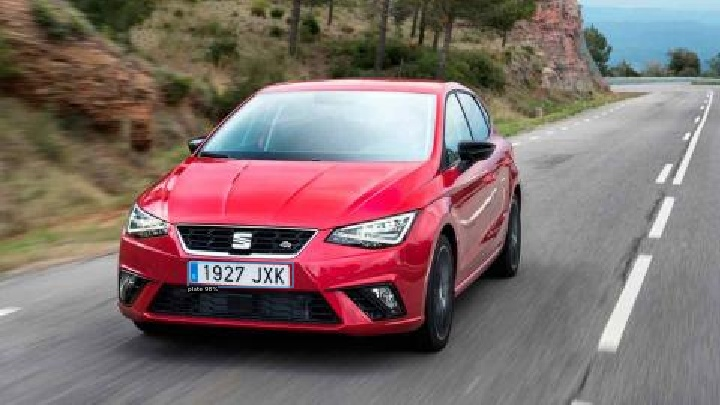

In [9]:
# Visualize the result
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt

v = Visualizer(im[:, :, ::-1],
  metadata=MetadataCatalog.get('plate_dataset'), 
  scale=1.5, 
  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
imshow(out.get_image(), reverse=True)

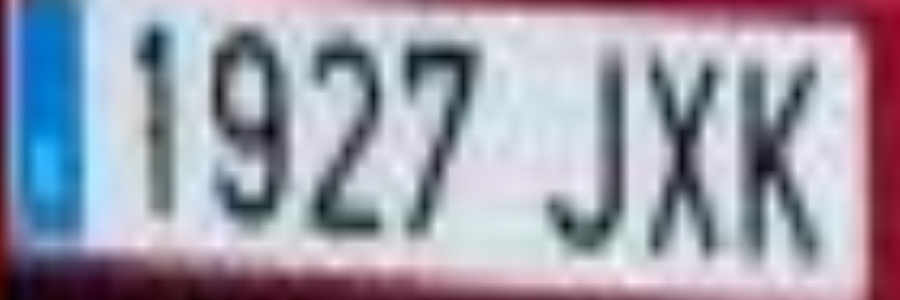

In [11]:
# Extract the car plate from the image
import matplotlib.pyplot as plt

xmin = bbox[1]
xmax = bbox[3]
ymin = bbox[0]
ymax = bbox[2]

pts_src = np.float32([[ymin, xmin], [ymin,xmax], [ymax,xmax], [ymax,xmin]])
pts_dst = np.float32([[0, 0], [0, 100], [300, 100],[300, 0]])*3

# Adapt perspective
M, _ = cv2.findHomography(pts_src, pts_dst)
no_perspective = cv2.warpPerspective(im, M, (900, 300))
imshow(no_perspective)

## Extraer el texto de la matricula

Para extraer la matrícula se usa el módulo `pytesseract` que permite extraer textos de una imagen con la función `image_to_string()`. Pero se tiene que tener en cuenta un factor importante, el tamaño de la imagen de la matrícula debe tener un tamaño adecuado para que la librería reconozca bien los caracteres. Es decir, si los caracteres son demasiado grandes o pequeños no se encontrarán todos los caracteres o se añadirán algunos que no existen.

En este caso, utilizamos la matricula extraida directamente de la imagen que permite reconocer bien los caracteres sin tener que corregir la perspectiva.

In [10]:
bbox = np.array(outputs['instances'].pred_boxes[0].tensor.cpu(), dtype='int')[0]
imshow(im[bbox[1]:bbox[3], bbox[0]:bbox[2]])

In [14]:
# Extract the text
import pytesseract
print(pytesseract.image_to_string(im[bbox[1]:bbox[3], bbox[0]:bbox[2]]))

1927 JXK

